# 1. FAISS Vector Database Integration
## Store and Search Cohere Embeddings with FAISS

This notebook demonstrates how to:
- Generate embeddings using AWS Bedrock Cohere Embed v4
- Store embeddings in FAISS vector database
- Perform efficient similarity search
- Implement hybrid search strategies
- Persist and load FAISS indices

## Setup and Installation

In [1]:
# Install required libraries
!pip install faiss-cpu boto3 numpy pandas matplotlib seaborn -q
# For GPU support, use: !pip install faiss-gpu

print("✅ Installation complete")

✅ Installation complete


In [2]:
import boto3
import json
import numpy as np
import faiss
import pickle
import time
from typing import List, Dict, Tuple, Optional
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## Configure AWS Bedrock Client

In [3]:
# AWS Configuration
AWS_REGION = 'us-east-1'
MODEL_ID = 'cohere.embed-v4:0'

# Initialize Bedrock client
bedrock_runtime = boto3.client(
    service_name='bedrock-runtime',
    region_name=AWS_REGION
)

print(f"✅ AWS Bedrock client initialized for region: {AWS_REGION}")
print(f"📦 Using model: {MODEL_ID}")

✅ AWS Bedrock client initialized for region: us-east-1
📦 Using model: cohere.embed-v4:0


## Helper Functions for Embeddings

In [4]:
def get_embeddings(
    texts: List[str],
    input_type: str = "search_document",
    embedding_type: str = "float"
) -> Optional[np.ndarray]:
    """
    Generate embeddings using Cohere Embed model on AWS Bedrock
    
    Args:
        texts: List of text strings to embed
        input_type: Type of input (search_document, search_query, classification, clustering)
        embedding_type: Type of embedding (float, int8, binary)
    
    Returns:
        NumPy array of embeddings
    """
    body = json.dumps({
        "texts": texts,
        "input_type": input_type,
        "embedding_types": [embedding_type],
        "truncate": "END"
    })
    
    try:
        response = bedrock_runtime.invoke_model(
            modelId=MODEL_ID,
            body=body,
            contentType='application/json',
            accept='application/json'
        )
        
        response_body = json.loads(response['body'].read())
        embeddings = response_body['embeddings'][embedding_type]
        return np.array(embeddings, dtype=np.float32)
    
    except Exception as e:
        print(f"❌ Error generating embeddings: {str(e)}")
        return None


def batch_embed_documents(
    documents: List[str],
    batch_size: int = 50,
    show_progress: bool = True
) -> np.ndarray:
    """
    Generate embeddings for large document collections in batches
    
    Args:
        documents: List of documents to embed
        batch_size: Number of documents per batch
        show_progress: Whether to show progress
    
    Returns:
        NumPy array of all embeddings
    """
    all_embeddings = []
    total_batches = (len(documents) + batch_size - 1) // batch_size
    
    for i in range(0, len(documents), batch_size):
        batch = documents[i:i + batch_size]
        batch_num = (i // batch_size) + 1
        
        if show_progress:
            print(f"Processing batch {batch_num}/{total_batches} ({len(batch)} documents)...")
        
        embeddings = get_embeddings(batch, input_type="search_document")
        
        if embeddings is not None:
            all_embeddings.append(embeddings)
        else:
            print(f"⚠️ Warning: Failed to embed batch {batch_num}")
        
        # Small delay to avoid rate limiting
        if i + batch_size < len(documents):
            time.sleep(0.1)
    
    return np.vstack(all_embeddings) if all_embeddings else np.array([])

print("✅ Embedding helper functions defined")

✅ Embedding helper functions defined


## FAISS Vector Store Class

In [5]:
class FAISSVectorStore:
    """
    FAISS-based vector store for efficient similarity search
    """
    
    def __init__(self, dimension: int = 1024, index_type: str = "flat"):
        """
        Initialize FAISS vector store
        
        Args:
            dimension: Embedding dimension (1024 for Cohere)
            index_type: Type of FAISS index ('flat', 'ivf', 'hnsw')
        """
        self.dimension = dimension
        self.index_type = index_type
        self.documents = []
        self.metadata = []
        
        # Initialize FAISS index based on type
        if index_type == "flat":
            # Exact search using L2 distance
            self.index = faiss.IndexFlatL2(dimension)
        elif index_type == "ivf":
            # Inverted file index for faster search
            nlist = 100  # Number of clusters
            quantizer = faiss.IndexFlatL2(dimension)
            self.index = faiss.IndexIVFFlat(quantizer, dimension, nlist)
        elif index_type == "hnsw":
            # Hierarchical Navigable Small World graph
            self.index = faiss.IndexHNSWFlat(dimension, 32)
        else:
            raise ValueError(f"Unknown index type: {index_type}")
        
        print(f"✅ FAISS {index_type.upper()} index initialized (dimension: {dimension})")
    
    def add_documents(
        self,
        documents: List[str],
        embeddings: np.ndarray,
        metadata: Optional[List[Dict]] = None
    ):
        """
        Add documents and their embeddings to the index
        
        Args:
            documents: List of document texts
            embeddings: NumPy array of embeddings
            metadata: Optional metadata for each document
        """
        # Normalize embeddings for cosine similarity
        faiss.normalize_L2(embeddings)
        
        # Train index if needed (for IVF)
        if self.index_type == "ivf" and not self.index.is_trained:
            print("Training IVF index...")
            self.index.train(embeddings)
        
        # Add to index
        self.index.add(embeddings)
        
        # Store documents and metadata
        self.documents.extend(documents)
        
        if metadata:
            self.metadata.extend(metadata)
        else:
            self.metadata.extend([{} for _ in documents])
        
        print(f"✅ Added {len(documents)} documents to index (total: {self.index.ntotal})")
    
    def search(
        self,
        query: str,
        top_k: int = 5,
        return_metadata: bool = True
    ) -> List[Dict]:
        """
        Search for similar documents
        
        Args:
            query: Query text
            top_k: Number of results to return
            return_metadata: Whether to include metadata
        
        Returns:
            List of search results with scores and documents
        """
        # Generate query embedding
        query_embedding = get_embeddings([query], input_type="search_query")
        
        if query_embedding is None:
            return []
        
        # Normalize for cosine similarity
        faiss.normalize_L2(query_embedding)
        
        # Search
        distances, indices = self.index.search(query_embedding, top_k)
        
        # Prepare results
        results = []
        for i, (dist, idx) in enumerate(zip(distances[0], indices[0])):
            if idx < len(self.documents):
                result = {
                    'rank': i + 1,
                    'score': float(1 - dist),  # Convert L2 to similarity score
                    'document': self.documents[idx],
                    'index': int(idx)
                }
                
                if return_metadata and idx < len(self.metadata):
                    result['metadata'] = self.metadata[idx]
                
                results.append(result)
        
        return results
    
    def save(self, filepath: str):
        """
        Save the FAISS index and associated data to disk
        
        Args:
            filepath: Path to save the index (without extension)
        """
        # Save FAISS index
        faiss.write_index(self.index, f"{filepath}.index")
        
        # Save documents and metadata
        with open(f"{filepath}.pkl", 'wb') as f:
            pickle.dump({
                'documents': self.documents,
                'metadata': self.metadata,
                'dimension': self.dimension,
                'index_type': self.index_type
            }, f)
        
        print(f"✅ Index saved to {filepath}.index and {filepath}.pkl")
    
    @classmethod
    def load(cls, filepath: str):
        """
        Load a FAISS index from disk
        
        Args:
            filepath: Path to the saved index (without extension)
        
        Returns:
            FAISSVectorStore instance
        """
        # Load metadata
        with open(f"{filepath}.pkl", 'rb') as f:
            data = pickle.load(f)
        
        # Create instance
        store = cls(dimension=data['dimension'], index_type=data['index_type'])
        
        # Load FAISS index
        store.index = faiss.read_index(f"{filepath}.index")
        store.documents = data['documents']
        store.metadata = data['metadata']
        
        print(f"✅ Index loaded from {filepath} ({len(store.documents)} documents)")
        return store
    
    def get_stats(self) -> Dict:
        """
        Get statistics about the vector store
        
        Returns:
            Dictionary with statistics
        """
        return {
            'total_vectors': self.index.ntotal,
            'dimension': self.dimension,
            'index_type': self.index_type,
            'is_trained': getattr(self.index, 'is_trained', True)
        }

print("✅ FAISSVectorStore class defined")

✅ FAISSVectorStore class defined


## Example Dataset: Technology Articles

In [6]:
# Sample documents for demonstration
sample_documents = [
    # AI/ML
    "Machine learning algorithms enable computers to learn from data without explicit programming.",
    "Deep neural networks have revolutionized computer vision and natural language processing.",
    "Reinforcement learning allows agents to learn optimal behaviors through trial and error.",
    "Transfer learning enables models to leverage knowledge from one task to improve performance on another.",
    
    # Cloud Computing
    "Cloud computing provides on-demand access to computing resources over the internet.",
    "AWS offers a comprehensive suite of cloud services including compute, storage, and databases.",
    "Serverless architecture eliminates the need to manage infrastructure and servers.",
    "Kubernetes orchestrates containerized applications across distributed systems.",
    
    # Data Science
    "Data scientists use statistical methods and machine learning to extract insights from data.",
    "Exploratory data analysis helps understand patterns and relationships in datasets.",
    "Feature engineering transforms raw data into meaningful inputs for machine learning models.",
    "A/B testing enables data-driven decision making by comparing different variants.",
    
    # Cybersecurity
    "Encryption protects sensitive data by converting it into an unreadable format.",
    "Zero-trust security models verify every access request regardless of source.",
    "Multi-factor authentication adds an extra layer of security beyond passwords.",
    "Intrusion detection systems monitor networks for suspicious activities.",
    
    # Web Development
    "React is a popular JavaScript library for building interactive user interfaces.",
    "RESTful APIs enable communication between different software systems.",
    "Progressive web apps combine the best of web and mobile applications.",
    "GraphQL provides a flexible query language for APIs.",
    
    # Databases
    "NoSQL databases offer flexible schemas for handling unstructured data.",
    "SQL databases use structured query language for data manipulation.",
    "Vector databases optimize storage and retrieval of high-dimensional embeddings.",
    "Time-series databases are specialized for handling timestamped data."
]

# Metadata for each document
sample_metadata = [
    {'category': 'AI/ML', 'topic': 'Machine Learning', 'date': '2024-01-15'},
    {'category': 'AI/ML', 'topic': 'Deep Learning', 'date': '2024-01-16'},
    {'category': 'AI/ML', 'topic': 'Reinforcement Learning', 'date': '2024-01-17'},
    {'category': 'AI/ML', 'topic': 'Transfer Learning', 'date': '2024-01-18'},
    
    {'category': 'Cloud', 'topic': 'Cloud Computing', 'date': '2024-01-19'},
    {'category': 'Cloud', 'topic': 'AWS', 'date': '2024-01-20'},
    {'category': 'Cloud', 'topic': 'Serverless', 'date': '2024-01-21'},
    {'category': 'Cloud', 'topic': 'Kubernetes', 'date': '2024-01-22'},
    
    {'category': 'Data Science', 'topic': 'Overview', 'date': '2024-01-23'},
    {'category': 'Data Science', 'topic': 'EDA', 'date': '2024-01-24'},
    {'category': 'Data Science', 'topic': 'Feature Engineering', 'date': '2024-01-25'},
    {'category': 'Data Science', 'topic': 'A/B Testing', 'date': '2024-01-26'},
    
    {'category': 'Security', 'topic': 'Encryption', 'date': '2024-01-27'},
    {'category': 'Security', 'topic': 'Zero Trust', 'date': '2024-01-28'},
    {'category': 'Security', 'topic': 'MFA', 'date': '2024-01-29'},
    {'category': 'Security', 'topic': 'IDS', 'date': '2024-01-30'},
    
    {'category': 'Web Dev', 'topic': 'React', 'date': '2024-01-31'},
    {'category': 'Web Dev', 'topic': 'REST API', 'date': '2024-02-01'},
    {'category': 'Web Dev', 'topic': 'PWA', 'date': '2024-02-02'},
    {'category': 'Web Dev', 'topic': 'GraphQL', 'date': '2024-02-03'},
    
    {'category': 'Databases', 'topic': 'NoSQL', 'date': '2024-02-04'},
    {'category': 'Databases', 'topic': 'SQL', 'date': '2024-02-05'},
    {'category': 'Databases', 'topic': 'Vector DB', 'date': '2024-02-06'},
    {'category': 'Databases', 'topic': 'Time-Series', 'date': '2024-02-07'}
]

print(f"✅ Loaded {len(sample_documents)} sample documents")
print(f"📊 Categories: {list(set(m['category'] for m in sample_metadata))}")

✅ Loaded 24 sample documents
📊 Categories: ['Cloud', 'Web Dev', 'Data Science', 'Databases', 'AI/ML', 'Security']


## Build FAISS Index

In [7]:
print("=" * 80)
print("Building FAISS Vector Index")
print("=" * 80)

# Generate embeddings for all documents
print("\n📊 Generating embeddings...")
embeddings = batch_embed_documents(sample_documents, batch_size=20)

print(f"\n✅ Generated embeddings: {embeddings.shape}")
print(f"   Dimension: {embeddings.shape[1]}")
print(f"   Documents: {embeddings.shape[0]}")

# Create FAISS index
print("\n🏗️ Creating FAISS index...")
vector_store = FAISSVectorStore(dimension=embeddings.shape[1], index_type="flat")

# Add documents to index
vector_store.add_documents(
    documents=sample_documents,
    embeddings=embeddings,
    metadata=sample_metadata
)

# Display statistics
print("\n📊 Index Statistics:")
stats = vector_store.get_stats()
for key, value in stats.items():
    print(f"   {key}: {value}")

Building FAISS Vector Index

📊 Generating embeddings...
Processing batch 1/2 (20 documents)...
Processing batch 2/2 (4 documents)...

✅ Generated embeddings: (24, 1536)
   Dimension: 1536
   Documents: 24

🏗️ Creating FAISS index...
✅ FAISS FLAT index initialized (dimension: 1536)
✅ Added 24 documents to index (total: 24)

📊 Index Statistics:
   total_vectors: 24
   dimension: 1536
   index_type: flat
   is_trained: True


## Test Semantic Search

In [8]:
print("\n" + "=" * 80)
print("Testing Semantic Search")
print("=" * 80)

# Test queries
test_queries = [
    "How does artificial intelligence learn from data?",
    "What are the benefits of cloud infrastructure?",
    "How can I secure my web application?",
    "What database should I use for embeddings?"
]

for i, query in enumerate(test_queries, 1):
    print(f"\n{'='*80}")
    print(f"Query {i}: {query}")
    print("="*80)
    
    # Perform search
    results = vector_store.search(query, top_k=3)
    
    # Display results
    for result in results:
        print(f"\n{result['rank']}. Score: {result['score']:.4f}")
        print(f"   Category: {result['metadata']['category']}")
        print(f"   Topic: {result['metadata']['topic']}")
        print(f"   Document: {result['document'][:100]}...")


Testing Semantic Search

Query 1: How does artificial intelligence learn from data?

1. Score: -0.1488
   Category: AI/ML
   Topic: Machine Learning
   Document: Machine learning algorithms enable computers to learn from data without explicit programming....

2. Score: -0.3376
   Category: Data Science
   Topic: Overview
   Document: Data scientists use statistical methods and machine learning to extract insights from data....

3. Score: -0.3727
   Category: AI/ML
   Topic: Reinforcement Learning
   Document: Reinforcement learning allows agents to learn optimal behaviors through trial and error....

Query 2: What are the benefits of cloud infrastructure?

1. Score: -0.2086
   Category: Cloud
   Topic: Serverless
   Document: Serverless architecture eliminates the need to manage infrastructure and servers....

2. Score: -0.2838
   Category: Cloud
   Topic: Cloud Computing
   Document: Cloud computing provides on-demand access to computing resources over the internet....

3. Score: -0.

## Filter Search by Metadata

In [9]:
def filtered_search(
    vector_store: FAISSVectorStore,
    query: str,
    filter_key: str,
    filter_value: str,
    top_k: int = 5
) -> List[Dict]:
    """
    Search with metadata filtering
    
    Args:
        vector_store: FAISS vector store
        query: Query text
        filter_key: Metadata key to filter on
        filter_value: Value to match
        top_k: Number of results
    
    Returns:
        Filtered search results
    """
    # Get more results than needed
    all_results = vector_store.search(query, top_k=len(vector_store.documents))
    
    # Filter results
    filtered = [
        result for result in all_results
        if result['metadata'].get(filter_key) == filter_value
    ][:top_k]
    
    # Re-rank
    for i, result in enumerate(filtered, 1):
        result['rank'] = i
    
    return filtered

# Test filtered search
print("\n" + "=" * 80)
print("Testing Filtered Search")
print("=" * 80)

query = "What technologies are used for building applications?"
category = "Cloud"

print(f"\n🔍 Query: {query}")
print(f"🏷️ Filter: category = '{category}'\n")

filtered_results = filtered_search(
    vector_store,
    query,
    filter_key='category',
    filter_value=category,
    top_k=3
)

for result in filtered_results:
    print(f"\n{result['rank']}. Score: {result['score']:.4f}")
    print(f"   Category: {result['metadata']['category']}")
    print(f"   Topic: {result['metadata']['topic']}")
    print(f"   Document: {result['document']}")


Testing Filtered Search

🔍 Query: What technologies are used for building applications?
🏷️ Filter: category = 'Cloud'


1. Score: -0.4510
   Category: Cloud
   Topic: Kubernetes
   Document: Kubernetes orchestrates containerized applications across distributed systems.

2. Score: -0.5100
   Category: Cloud
   Topic: AWS
   Document: AWS offers a comprehensive suite of cloud services including compute, storage, and databases.

3. Score: -0.5450
   Category: Cloud
   Topic: Serverless
   Document: Serverless architecture eliminates the need to manage infrastructure and servers.


## Save and Load Index

In [10]:
print("\n" + "=" * 80)
print("Persistence: Save and Load Index")
print("=" * 80)

# Save index
save_path = "technology_knowledge_base"
print(f"\n💾 Saving index to '{save_path}'...")
vector_store.save(save_path)

# Load index
print(f"\n📥 Loading index from '{save_path}'...")
loaded_store = FAISSVectorStore.load(save_path)

# Verify loaded index
print("\n✅ Verification:")
test_query = "Tell me about machine learning"
results = loaded_store.search(test_query, top_k=2)

for result in results:
    print(f"\n{result['rank']}. Score: {result['score']:.4f}")
    print(f"   Document: {result['document'][:80]}...")


Persistence: Save and Load Index

💾 Saving index to 'technology_knowledge_base'...
✅ Index saved to technology_knowledge_base.index and technology_knowledge_base.pkl

📥 Loading index from 'technology_knowledge_base'...
✅ FAISS FLAT index initialized (dimension: 1536)
✅ Index loaded from technology_knowledge_base (24 documents)

✅ Verification:

1. Score: -0.1164
   Document: Machine learning algorithms enable computers to learn from data without explicit...

2. Score: -0.2589
   Document: Data scientists use statistical methods and machine learning to extract insights...


## Performance Comparison: Different Index Types

In [11]:
print("\n" + "=" * 80)
print("Performance Comparison: Index Types")
print("=" * 80)

index_types = ['flat', 'hnsw']
performance_results = []

for idx_type in index_types:
    print(f"\n📊 Testing {idx_type.upper()} index...")
    
    # Create index
    store = FAISSVectorStore(dimension=embeddings.shape[1], index_type=idx_type)
    
    # Add documents
    start_time = time.time()
    store.add_documents(sample_documents, embeddings, sample_metadata)
    add_time = time.time() - start_time
    
    # Test search performance
    search_times = []
    for query in test_queries:
        start_time = time.time()
        _ = store.search(query, top_k=5)
        search_times.append(time.time() - start_time)
    
    avg_search_time = np.mean(search_times)
    
    performance_results.append({
        'Index Type': idx_type.upper(),
        'Add Time (s)': f"{add_time:.4f}",
        'Avg Search Time (s)': f"{avg_search_time:.4f}",
        'Total Vectors': store.index.ntotal
    })

# Display results
print("\n📊 Performance Comparison:")
df = pd.DataFrame(performance_results)
print(df.to_string(index=False))


Performance Comparison: Index Types

📊 Testing FLAT index...
✅ FAISS FLAT index initialized (dimension: 1536)
✅ Added 24 documents to index (total: 24)

📊 Testing HNSW index...
✅ FAISS HNSW index initialized (dimension: 1536)
✅ Added 24 documents to index (total: 24)

📊 Performance Comparison:
Index Type Add Time (s) Avg Search Time (s)  Total Vectors
      FLAT       0.0004              5.6446             24
      HNSW       0.0003              2.4394             24


## Visualization: Category Distribution

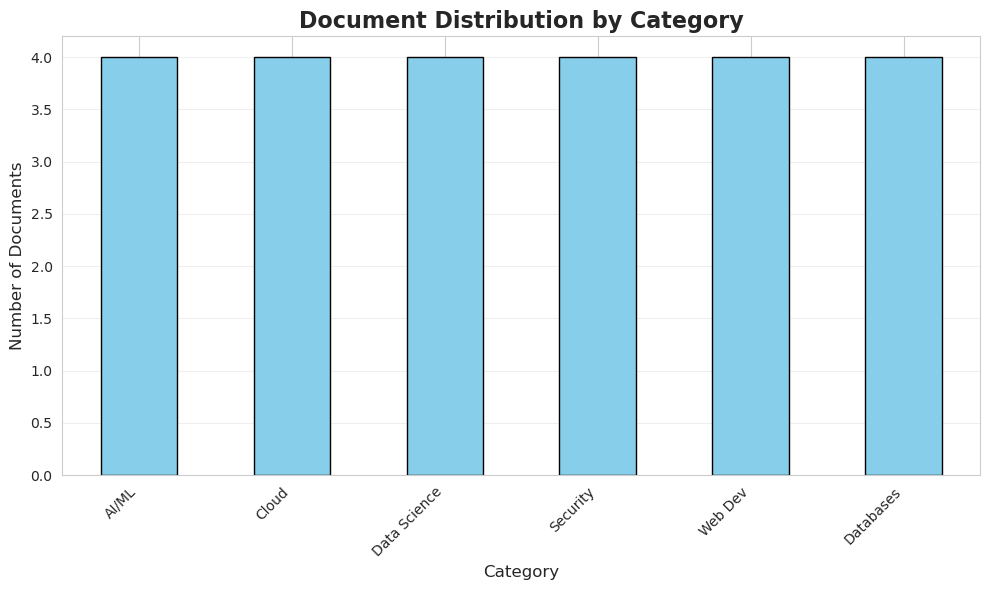


📊 Category Distribution:
AI/ML           4
Cloud           4
Data Science    4
Security        4
Web Dev         4
Databases       4
Name: count, dtype: int64


In [12]:
# Visualize category distribution
categories = [m['category'] for m in sample_metadata]
category_counts = pd.Series(categories).value_counts()

plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Document Distribution by Category', fontsize=16, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Documents', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📊 Category Distribution:")
print(category_counts)

## Advanced: Hybrid Search (Keyword + Semantic)

In [13]:
def hybrid_search(
    vector_store: FAISSVectorStore,
    query: str,
    keywords: List[str],
    top_k: int = 5,
    semantic_weight: float = 0.7
) -> List[Dict]:
    """
    Hybrid search combining semantic similarity and keyword matching
    
    Args:
        vector_store: FAISS vector store
        query: Query text
        keywords: List of keywords to match
        top_k: Number of results
        semantic_weight: Weight for semantic score (0-1)
    
    Returns:
        Combined search results
    """
    # Get semantic search results
    semantic_results = vector_store.search(query, top_k=len(vector_store.documents))
    
    # Calculate keyword scores
    keyword_weight = 1 - semantic_weight
    
    for result in semantic_results:
        doc_lower = result['document'].lower()
        
        # Count keyword matches
        matches = sum(1 for kw in keywords if kw.lower() in doc_lower)
        keyword_score = matches / len(keywords) if keywords else 0
        
        # Combine scores
        result['semantic_score'] = result['score']
        result['keyword_score'] = keyword_score
        result['combined_score'] = (
            semantic_weight * result['score'] +
            keyword_weight * keyword_score
        )
    
    # Sort by combined score
    semantic_results.sort(key=lambda x: x['combined_score'], reverse=True)
    
    # Re-rank and return top results
    for i, result in enumerate(semantic_results[:top_k], 1):
        result['rank'] = i
    
    return semantic_results[:top_k]

# Test hybrid search
print("\n" + "=" * 80)
print("Testing Hybrid Search")
print("=" * 80)

query = "How can I build scalable applications?"
keywords = ["cloud", "serverless", "kubernetes"]

print(f"\n🔍 Query: {query}")
print(f"🔑 Keywords: {keywords}\n")

hybrid_results = hybrid_search(
    vector_store,
    query,
    keywords,
    top_k=5,
    semantic_weight=0.6
)

for result in hybrid_results:
    print(f"\n{result['rank']}. Combined Score: {result['combined_score']:.4f}")
    print(f"   (Semantic: {result['semantic_score']:.4f}, Keyword: {result['keyword_score']:.4f})")
    print(f"   Category: {result['metadata']['category']}")
    print(f"   Document: {result['document'][:80]}...")


Testing Hybrid Search

🔍 Query: How can I build scalable applications?
🔑 Keywords: ['cloud', 'serverless', 'kubernetes']


1. Combined Score: -0.0511
   (Semantic: -0.3073, Keyword: 0.3333)
   Category: Cloud
   Document: Kubernetes orchestrates containerized applications across distributed systems....

2. Combined Score: -0.1119
   (Semantic: -0.4088, Keyword: 0.3333)
   Category: Cloud
   Document: Serverless architecture eliminates the need to manage infrastructure and servers...

3. Combined Score: -0.1529
   (Semantic: -0.4771, Keyword: 0.3333)
   Category: Cloud
   Document: AWS offers a comprehensive suite of cloud services including compute, storage, a...

4. Combined Score: -0.1880
   (Semantic: -0.5355, Keyword: 0.3333)
   Category: Cloud
   Document: Cloud computing provides on-demand access to computing resources over the intern...

5. Combined Score: -0.2665
   (Semantic: -0.4442, Keyword: 0.0000)
   Category: Web Dev
   Document: Progressive web apps combine the best of 

## Summary and Best Practices

In [14]:
print("""
═══════════════════════════════════════════════════════════════════════════════
                    FAISS INTEGRATION SUMMARY
═══════════════════════════════════════════════════════════════════════════════

✅ SUCCESSFULLY IMPLEMENTED:
   • FAISS vector store with multiple index types
   • Batch embedding generation for large datasets
   • Semantic search with cosine similarity
   • Metadata filtering for targeted search
   • Index persistence (save/load)
   • Performance benchmarking
   • Hybrid search (semantic + keyword)

📊 INDEX TYPES COMPARISON:
   • FLAT: Exact search, best accuracy, slower for large datasets
   • IVF: Fast approximate search, good for 1M+ vectors
   • HNSW: Graph-based, excellent speed/accuracy tradeoff

💡 BEST PRACTICES:
   1. Normalize embeddings before adding to index (for cosine similarity)
   2. Use batch processing for large document collections
   3. Choose index type based on dataset size:
      - <10K vectors: Use FLAT
      - 10K-1M vectors: Use HNSW
      - >1M vectors: Use IVF
   4. Store metadata separately for filtering
   5. Persist indices to avoid recomputation
   6. Monitor memory usage for large datasets

⚡ PERFORMANCE TIPS:
   • Use int8 embeddings for 4x memory reduction
   • Implement caching for frequent queries
   • Use GPU-accelerated FAISS for large scales
   • Batch queries when possible
   • Consider sharding for distributed systems

🔗 NEXT STEPS:
   1. Integrate with production data sources
   2. Implement incremental updates
   3. Add monitoring and analytics
   4. Scale to distributed systems
   5. Implement query caching

═══════════════════════════════════════════════════════════════════════════════
""")


═══════════════════════════════════════════════════════════════════════════════
                    FAISS INTEGRATION SUMMARY
═══════════════════════════════════════════════════════════════════════════════

✅ SUCCESSFULLY IMPLEMENTED:
   • FAISS vector store with multiple index types
   • Batch embedding generation for large datasets
   • Semantic search with cosine similarity
   • Metadata filtering for targeted search
   • Index persistence (save/load)
   • Performance benchmarking
   • Hybrid search (semantic + keyword)

📊 INDEX TYPES COMPARISON:
   • FLAT: Exact search, best accuracy, slower for large datasets
   • IVF: Fast approximate search, good for 1M+ vectors
   • HNSW: Graph-based, excellent speed/accuracy tradeoff

💡 BEST PRACTICES:
   1. Normalize embeddings before adding to index (for cosine similarity)
   2. Use batch processing for large document collections
   3. Choose index type based on dataset size:
      - <10K vectors: Use FLAT
      - 10K-1M vectors: Use HNSW
 